# Import packages

In [1]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision as tv
import pandas as pd
import time

# Determine using CPU or GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Load and show the images

In [3]:
def load_image(file_name, size):
        transform = tv.transforms.Compose([
        tv.transforms.Resize(size),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        img = Image.open(file_name)
        img = transform(img)
        return img
c = load_image("content.jpg", [128, 128])  # content image
s = load_image("style.jpg", [128, 128])   # style image

In [4]:
def myimshow(image, ax=plt):
        image = image.to('cpu').numpy()
        image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
        image = (image + 1) / 2
        image[image < 0] = 0
        image[image > 1] = 1 
        h = ax.imshow(image) 
        ax.axis('off') 
        return h

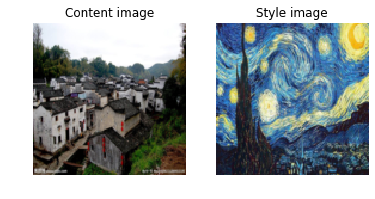

In [5]:
plt.subplot(1, 2, 1)
plt.title("Content image")
myimshow(c)

plt.subplot(1, 2, 2)
plt.title("Style image")
myimshow(s)

In [6]:
c = c.view(1, c.shape[0], c.shape[1], c.shape[2])   # convert to 4 dimension
s = s.view(1, s.shape[0], s.shape[1], s.shape[2])   # convert to 4 dimension
print(c.shape)
print(s.shape)

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


# Calculate the content loss

In [7]:
def Cal_content_loss(F_l, P_l):
        '''
        input:
            F_l--feature map for generated image at layer l
            P_l--feature map for content image at layer l
        
        return:
            content_loss, denoted as c_loss
        '''
        P_l = P_l.detach()
        #loss_func = nn.MSELoss()
        #c_loss = loss_func(F_l, P_l)
        c_loss = torch.mean((F_l - P_l) ** 2)
        return c_loss

# Calculate the style loss

In [8]:
def Cal_gram_matrix(F_l):
        '''
        F_l--feature map at layer l, 4 dimensional torch
        return: Gram matrix, denoted as G
        '''
        a, b, c, d = F_l.size()
        features = F_l.view(a*b, c*d)              # change feature map to be two dimension
        G = torch.mm(features, features.t())  # Gram matrix
        #G /= (a * b * c * d)
        return G     
    
def Cal_style_loss(G_l, A_l):
        '''
        Input:
            G_l--gram matrix for generated image feature map at layer l
            A_l--gram matrix for style image feature map at layer l
            
        return: 
            style_loss, denoted as s_loss
        '''
        A_l = A_l.detach()
        #loss_func = nn.MSELoss()
        #s_loss = loss_func(G_l, A_l)
        s_loss = torch.mean((G_l - A_l) ** 2)
        return s_loss

# Modify the VGG19

In [9]:
vgg = models.vgg19(pretrained=True).to(device)  # use cuda

In [10]:
class VGG19Transfer(nn.Module):

        def __init__(self, fine_tuning=False):
                super(VGG19Transfer, self).__init__()
                vgg = models.vgg19(pretrained=True).to(device).eval()
                
                for param in vgg.parameters():
                        param.requires_grad = fine_tuning
                self.features = vgg.features

                self.model = nn.ModuleList()    

                for layer in self.features:
                        if (type(layer) == nn.MaxPool2d):
                                self.model.append(nn.AvgPool2d(kernel_size=2,stride=2,padding=0))
                                continue

                        self.model.append(layer)

        def forward(self, x):
                num_conv = 0
                feature_map = []
                h = x.cuda()
                for layer in self.model:
                        h = layer(h)
                        if (type(layer) == nn.Conv2d):
                                num_conv += 1
                                feature_map.append(h)               
                return feature_map              

# Run the network

In [11]:
def run(net, device, num_epochs, c, s):
    
        start_epoch = 0
        C_num = [8]    #choose the Conv layer of content image 
        S_num = [0,2,4,8,12]   #choose the Conv layer of style image
        X = c.clone().to(device)   
        #X = torch.randn(c.size())    #generated image
        
        z1= net.forward(c)
        z2=net.forward(s)
        
        P=[]      # feature map for content image with corresponding layer
        S = []    # feature map for style image with corresponding layer
        for i in range(len(C_num)):
                P.append(z1[C_num[i]])
        for i in range(len(S_num)):
                S.append(z2[S_num[i]])
        
        
        lr = 1e-3
        X = nn.Parameter(X , requires_grad = True )
        optimizer = torch.optim.Adam([X], lr = lr)
        loss_to_plot=[]
        print("Start/Continue training from epoch {}".format(start_epoch))
        for epoch in range(start_epoch, num_epochs):
                s = time.time()                   
                optimizer.zero_grad()                     
                style_loss = 0
                content_loss=0
                
                F=net.forward(X)
                for i in range(len(S_num)):
                        FF_l = F[S_num[i]]   # feature map for generated image
                        G_l = Cal_gram_matrix(FF_l)          # gram matrix for feature map FF_l
                        A_l = Cal_gram_matrix(S[i].detach())       # gram matrix for feature map S[i]
                        s_loss = Cal_style_loss(G_l, A_l)/(FF_l.shape[1] * FF_l.shape[2] * FF_l.shape[3])
                        style_loss += s_loss
                for i in range(len(C_num)):       
                        F_l = F[C_num[i]]
                        c_loss = Cal_content_loss(F_l,P[i])
                        content_loss+=c_loss

                style_loss/=len(S_num)
                loss = (content_loss +  100*style_loss)
                loss_to_plot.append(loss)
                loss.backward()
                optimizer.step()
                if (epoch%500 == 0):
                        plt.figure()
                        tmp = X.detach().view(3, 128, 128).clone()
                        myimshow(tmp)
                        print("Epoch {} (Time: {:.2f}s) loss={} style_loss={}, content_loss={}".format(epoch, time.time() - s,loss, style_loss, c_loss))           
        print("Finish training for {} epochs".format(num_epochs))
        return X,loss_to_plot

Start/Continue training from epoch 0
Epoch 0 (Time: 0.08s) loss=23.834232330322266 style_loss=0.2383423149585724, content_loss=0.0
Epoch 500 (Time: 0.05s) loss=1.5400981903076172 style_loss=0.01222460437566042, content_loss=0.3176378607749939
Epoch 1000 (Time: 0.08s) loss=0.9322211742401123 style_loss=0.006333497818559408, content_loss=0.29887136816978455
Epoch 1500 (Time: 0.07s) loss=0.7604639530181885 style_loss=0.00477844150736928, content_loss=0.28261980414390564
Epoch 2000 (Time: 0.07s) loss=0.6621017456054688 style_loss=0.003909321967512369, content_loss=0.271169513463974
Epoch 2500 (Time: 0.09s) loss=0.5995001196861267 style_loss=0.003368921345099807, content_loss=0.26260799169540405
Epoch 3000 (Time: 0.10s) loss=0.5572587251663208 style_loss=0.0030187766533344984, content_loss=0.2553810477256775
Epoch 3500 (Time: 0.10s) loss=0.5280355215072632 style_loss=0.0027839106041938066, content_loss=0.249644473195076
Epoch 4000 (Time: 0.07s) loss=0.5069679021835327 style_loss=0.002624454

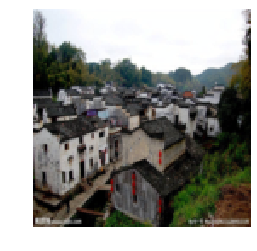

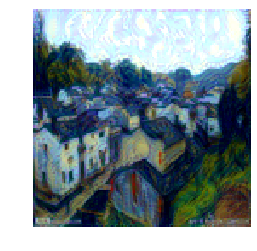

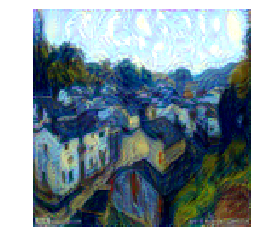

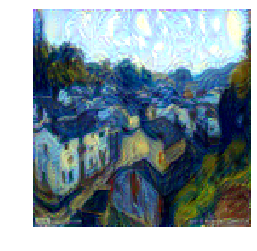

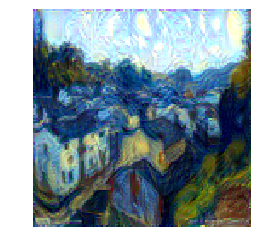

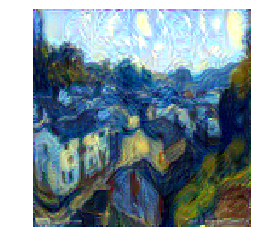

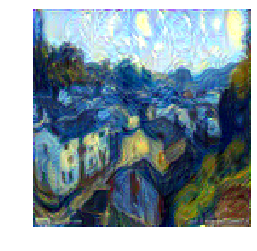

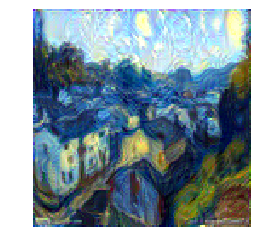

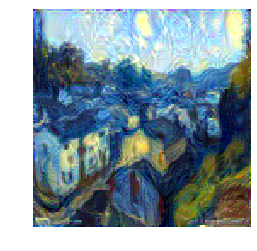

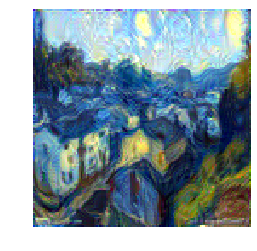

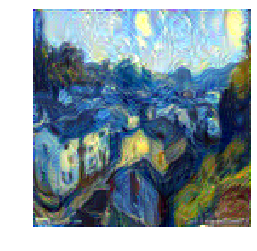

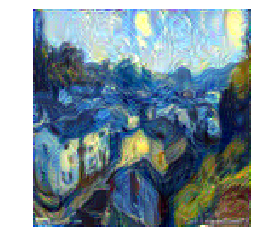

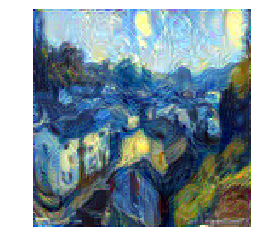

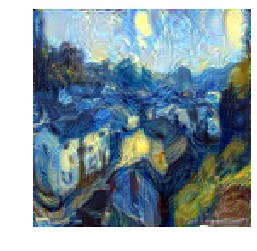

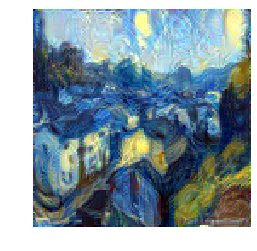

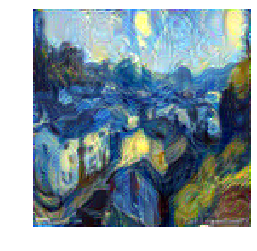

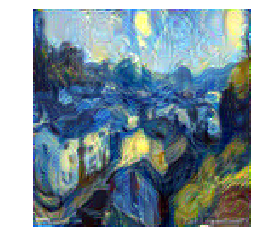

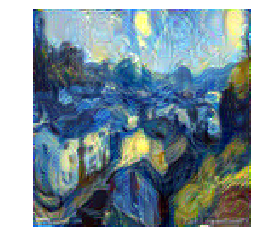

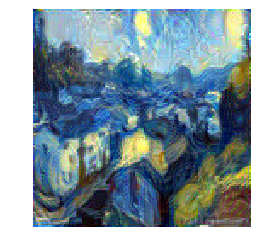

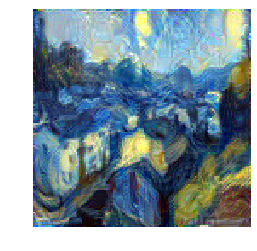

In [12]:
net=VGG19Transfer()
net=net.to(device)
X,loss_to_plot = run(net, device, 10000, c, s)

## Result show

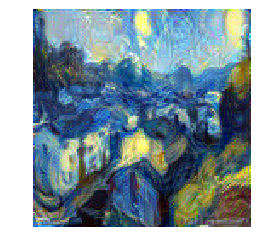

In [13]:
X = X.detach().view(3, 128, 128)
myimshow(X)

Text(0, 0.5, 'loss')

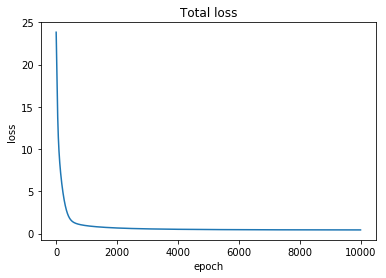

In [14]:
plt.plot(loss_to_plot)
plt.title('Total loss')
plt.xlabel('epoch')
plt.ylabel('loss')